# Satria Data - Big Data Challenge (BDC)
- Kode Kelompok - SD2024040000382
- Kode Registrasi - SATRIADATA24-1028170717
- Cabang Lomba - Big Data Challenge (BDC)
- Perguruan Tinggi - Universitas Bina Nusantara
- Pembimbing - Lili Ayu Wulandhari, S.Si., M.Sc., Ph.D
- PT Pembimbing - Universitas Bina Nusantara (BINUS)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/SATRIA DATA/PENYISIHAN/BDC-SatriaData-2024/dataset_penyisihan_bdc_2024.csv"

# Data Preparation

### Import Library

In [ ]:
import pandas as pd
import pickle
import re
import string
import nltk
from nlp_id.stopword import StopWord
import nlpaug
import nlpaug.augmenter.word as naw
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, log_loss
import warnings
warnings.filterwarnings('ignore')

### Read Dataset

In [ ]:
df = pd.read_csv(path, sep=None, engine='python')

In [ ]:
df.head()

,text,label
0,Kunjungan Prabowo ini untuk meresmikan dan men...,Sumber Daya Alam
1,RT Anies dapat tepuk tangan meriah saat jadi R...,Politik
2,@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...,Demografi
3,RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...,Politik
4,Anies Baswedan Harap ASN termasuk TNI dan Polr...,Politik


In [ ]:
df.tail()

,text,label
4995,RT @l1DsGGe2xObT3t72dHwqlT58X7jvEYtEnauZIZSYwS...,Politik
4996,Masyarakat yakin bahwa Prabowo-Gibran memiliki...,Politik
4997,imo both are irrational but yg satu jauh lebih...,Ekonomi
4998,@cIIGSdjaPrmAQY1E4gWnLpIZSdyQn8ZMhjJzgOsxfRM= ...,Pertahanan dan Keamanan
4999,"Acara ini tidak hanya memasak, tetapi Calon Pr...",Sumber Daya Alam


### Label Encoding

In [ ]:
df['label'].value_counts()

label
Politik                    2972
Sosial Budaya               587
Pertahanan dan Keamanan     400
Ideologi                    400
Ekonomi                     367
Sumber Daya Alam            192
Demografi                    62
Geografi                     20
Name: count, dtype: int64

In [ ]:
label_encode = {"label": {"Politik": 0,
                        "Sosial Budaya": 1,
                        "Pertahanan dan Keamanan": 2,
                        "Ideologi": 3,
                        "Ekonomi": 4,
                        "Sumber Daya Alam": 5,
                        "Demografi": 6,
                        "Geografi": 7}}
df_encode = df.replace(label_encode)

In [ ]:
df_encode.head()

,text,label
0,Kunjungan Prabowo ini untuk meresmikan dan men...,5
1,RT Anies dapat tepuk tangan meriah saat jadi R...,0
2,@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...,6
3,RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...,0
4,Anies Baswedan Harap ASN termasuk TNI dan Polr...,0


In [ ]:
df_encode['label'].value_counts()

label
0    2972
1     587
2     400
3     400
4     367
5     192
6      62
7      20
Name: count, dtype: int64

In [ ]:
df_encode

,text,label
0,Kunjungan Prabowo ini untuk meresmikan dan men...,5
1,RT Anies dapat tepuk tangan meriah saat jadi R...,0
2,@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...,6
3,RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...,0
4,Anies Baswedan Harap ASN termasuk TNI dan Polr...,0
...,...,...
4995,RT @l1DsGGe2xObT3t72dHwqlT58X7jvEYtEnauZIZSYwS...,0
4996,Masyarakat yakin bahwa Prabowo-Gibran memiliki...,0
4997,imo both are irrational but yg satu jauh lebih...,4
4998,@cIIGSdjaPrmAQY1E4gWnLpIZSdyQn8ZMhjJzgOsxfRM= ...,2


# Data Preprocessing

## Data Cleaning

In [ ]:
def remove_mentions(text):
    words = text.split()
    words = [word for word in words if not word.startswith('@')]
    return ' '.join(words)

df_encode['text'] = df_encode['text'].apply(remove_mentions)

In [ ]:
def remove_re_pattern(text):
    pattern = r'\[RE [^\]]*\]'
    text = re.sub(pattern, '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_encode['text'] = df_encode['text'].apply(remove_re_pattern)

In [ ]:
df_encode['text'] = df_encode['text'].str.replace(r'\brt\b', '', regex=True, case=False)

In [ ]:
def process_hashtags(text):
    def split_camel_case(s):
        return re.sub(r'([a-z])([A-Z])', r'\1 \2', s)
    words = text.split()
    processed_words = []
    for word in words:
        if word.startswith('#'):
            hashtag = word[1:]
            if hashtag.isupper():
                processed_words.append(hashtag)
            else:
                processed_words.extend(split_camel_case(hashtag).split())
        else:
            processed_words.append(word)
    return ' '.join(processed_words)

df_encode['text'] = df_encode['text'].apply(process_hashtags)

In [ ]:
def cleansing(df):
    df_clean = df.str.lower()
    df_clean = [re.sub(r"http\S+|www\S+|https\S+", "", i, flags=re.MULTILINE) for i in df_clean]
    df_clean = [re.sub(r"\d+", "", i) for i in df_clean]
    df_clean = [re.sub(r'[^\x00-\x7F]+', '', i) for i in df_clean]
    df_clean = [re.sub(r'[^\w\s]', ' ', i) for i in df_clean]
    df_clean = [re.sub(r'\s+', ' ', i) for i in df_clean]
    df_clean = [re.sub(r'[^a-zA-Z0-9\s]', '', i) for i in df_clean]
    df_clean = [re.sub(r'_', ' ', i) for i in df_clean]
    return df_clean

df_encode['clean_text'] = cleansing(df_encode['text'])

In [ ]:
def remove_trailing_spaces(text):
    text = text.strip()
    return text

df_encode['clean_text'] = df_encode['clean_text'].apply(remove_trailing_spaces)

Shows before & after pre-processing

In [ ]:
print(df['text'].iloc[7 - 2])
print(df_encode['clean_text'].iloc[7 - 2])

RT Duh jangan sampai Pak lurah denger nih Ã°ÂŸÂ¤Â­ Di Acara Hajatan Rakyat, Puluhan Ribu Warga di Kendal Serukan Ã¢Â€ÂœGanjar PresidenÃ¢Â€Â Kehadiran @0Zdeh9QcTWu+z+fS3hRaTcFuSLRh56REFyRLq4/Jdlc= menjadi magnet bagi puluhan ribu warga untuk datang menghadiri Hajatan Rakyat Ganjar-Mahfud. Besarnya antusiasme warga menjadi bukti bahwa Jawa Tengah tetap menjadi kandang banteng. #GanjarMahfud2024 #TabrakProfMahfud [RE DS_yantie]
duh jangan sampai pak lurah denger nih di acara hajatan rakyat puluhan ribu warga di kendal serukan ganjar presiden kehadiran menjadi magnet bagi puluhan ribu warga untuk datang menghadiri hajatan rakyat ganjar mahfud besarnya antusiasme warga menjadi bukti bahwa jawa tengah tetap menjadi kandang banteng ganjar mahfud tabrak prof mahfud


In [ ]:
df_encode

,text,label,clean_text
0,Kunjungan Prabowo ini untuk meresmikan dan men...,5,kunjungan prabowo ini untuk meresmikan dan men...
1,Anies dapat tepuk tangan meriah saat jadi Rekt...,0,anies dapat tepuk tangan meriah saat jadi rekt...
2,"emng bener sih, pendukung 01 ada yg goblok, be...",6,emng bener sih pendukung ada yg goblok begitu ...
3,Sewaktu anies bersikap kritis ke kinerja pak p...,0,sewaktu anies bersikap kritis ke kinerja pak p...
4,Anies Baswedan Harap ASN termasuk TNI dan Polr...,0,anies baswedan harap asn termasuk tni dan polr...
...,...,...,...
4995,"Ngeliat debat kemaren pas prabowo kicep, kekir...",0,ngeliat debat kemaren pas prabowo kicep kekira...
4996,Masyarakat yakin bahwa Prabowo-Gibran memiliki...,0,masyarakat yakin bahwa prabowo gibran memiliki...
4997,imo both are irrational but yg satu jauh lebih...,4,imo both are irrational but yg satu jauh lebih...
4998,"look at that pak ganjar, anda sdh berkecimpung...",2,look at that pak ganjar anda sdh berkecimpung ...


## Remove Stopwords

In [ ]:
stopword = StopWord()
stopword_list = stopword.get_stopword()

def remove_stopwords(text):
    words = text.split()
    clean_words = [word for word in words if word not in stopword_list]
    return ' '.join(clean_words)

df_encode['clean_stopword'] = df_encode['clean_text'].apply(remove_stopwords)

Max Length in Sentence

In [ ]:
max_length_in_sen = df_encode['clean_stopword'].str.split().str.len().max()
max_length_in_sen

342

# Data Splitting

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_encode['clean_stopword'], df_encode['label'], test_size = 0.2, random_state = 42
                                                    ,stratify =df_encode['label'])

In [ ]:
df_train = pd.DataFrame({'Text': x_train, 'Label': y_train})
df_test = pd.DataFrame({'Text': x_test, 'Label': y_test})

In [ ]:
df_train['Label'].value_counts()

Label
0    2378
1     470
3     320
2     320
4     294
5     153
6      49
7      16
Name: count, dtype: int64

In [ ]:
df_train.isna().sum()

Text     0
Label    0
dtype: int64

In [ ]:
df_test['Label'].value_counts()

Label
0    594
1    117
2     80
3     80
4     73
5     39
6     13
7      4
Name: count, dtype: int64

## Data Augmentation

- Label 0: Politik (No augmentation) --> x1
- Label 1: Sosial Budaya --> x5
- Label 2: Pertahanan dan Keamanan --> x7
- Label 3: Ideologi --> x7
- Label 4: Ekonomi --> x8
- Label 5: Sumber Daya Alam --> x15
- Label 6: Demografi --> x48
- Label 7: Geografi --> x150

### Class: 7 Augmentation

In [ ]:
texts = df_train['Text'].tolist()
labels = df_train['Label'].tolist()
class_7 = [7]

aug = naw.ContextualWordEmbsAug(
    model_path='indolem/indobert-base-uncased',
    model_type='bert',
    action='substitute',
    aug_max=3
)

augmented_texts = []
augmented_labels = []

for text, label in zip(texts, labels):
    if label in class_7:
        try:
            augmented_list = aug.augment(text, n=148)
            print(augmented_list)
            if augmented_list:
                augmented_texts.append(text)
                augmented_texts.extend(augmented_list)
                augmented_labels.append(label)
                augmented_labels.extend([label] * len(augmented_list))
            else:
                augmented_texts.append(text)
                augmented_labels.append(label)
        except Exception as e:
            print(f"Gagal mengaugmentasi teks: {text}")
            print(f"Error: {str(e)}")
            augmented_texts.append(text)
            augmented_labels.append(label)
    else:
        augmented_texts.append(text)
        augmented_labels.append(label)

df_train_class7 = pd.DataFrame({'Text': augmented_texts, 'Label': augmented_labels})

In [ ]:
df_train_class7['Label'].value_counts()

Label
7    2384
0    2378
1     470
3     320
2     320
4     294
5     153
6      49
Name: count, dtype: int64

In [ ]:
file_path = '/content/drive/MyDrive/SATRIA DATA/PENYISIHAN/'
df_train_class7.to_csv(file_path + 'df_train_class7.csv', index=False)

In [ ]:
df_train_class7.loc[df_train_class7['Label'] == 7]

,Text,Label
605,temen w komentar anies janji manis aslinya w c...,7
606,temen w komentar itu janji tidak aslinya w cap...,7
607,temen w komentar anies atau manis satu w capre...,7
608,langsung w komentar anies janji manis aslinya ...,7
609,temen w komentar akan janji manis aslinya w ca...,7
...,...,...
6265,ditakedown jakarta amp bekasi videotron anies ...,7
6266,ditakedown asia amp bekasi videotron anies mun...,7
6267,ditakedown stadium amp bekasi berita anies mun...,7
6268,ditakedown jakarta amp bekasi baru anies muncu...,7


In [ ]:
path_7 = '/content/drive/MyDrive/SATRIA DATA/PENYISIHAN/df_train_class7.csv'
df_7 = pd.read_csv(path_7, sep=None, engine='python')
df_7

,Text,Label
0,calon presiden ri no urut ganjar pranowo konst...,3
1,rakyat jabar mari bersatu berjuang prabowo adi...,0
2,mahasiswa melawan dinasti politik jokowi mahas...,0
3,baksos pemeriksaan kesehatan gratis nusa tengg...,0
4,kesempatan prabowo subianto mengikuti masak be...,4
...,...,...
6363,rilis terbaru nih bedanya kubu prabowo gibran ...,0
6364,peringatan hut partai demokrasi indonesia perj...,0
6365,minoritas mengakui gedeg dgn menyadari mengana...,1
6366,eks menhan era gus dur mahfud md paham uu raha...,0


In [ ]:
df_7['Label'].value_counts()

Label
7    2384
0    2378
1     470
3     320
2     320
4     294
5     153
6      49
Name: count, dtype: int64

### Class: 6 Augmentation

In [ ]:
texts = df_7['Text'].tolist()
labels = df_7['Label'].tolist()
class_6 = [6]

aug = naw.ContextualWordEmbsAug(
    model_path='indolem/indobert-base-uncased',
    model_type='bert',
    action='substitute',
    aug_max=3
)

augmented_texts = []
augmented_labels = []

for text, label in zip(texts, labels):
    if label in class_6:
        try:
            augmented_list = aug.augment(text, n=48)
            print(augmented_list)
            if augmented_list:
                augmented_texts.append(text)
                augmented_texts.extend(augmented_list)
                augmented_labels.append(label)
                augmented_labels.extend([label] * len(augmented_list))
            else:
                augmented_texts.append(text)
                augmented_labels.append(label)
        except Exception as e:
            print(f"Gagal mengaugmentasi teks: {text}")
            print(f"Error: {str(e)}")
            augmented_texts.append(text)
            augmented_labels.append(label)
    else:
        augmented_texts.append(text)
        augmented_labels.append(label)

df_train_class67 = pd.DataFrame({'Text': augmented_texts, 'Label': augmented_labels})

In [ ]:
df_train_class67['Label'].value_counts()

In [ ]:
file_path = '/content/drive/MyDrive/SATRIA DATA/PENYISIHAN/'
df_train_class67.to_csv(file_path + 'df_train_class67.csv', index=False)

In [ ]:
df_train_class67.loc[df_train_class67['Label'] == 6]

In [ ]:
path_67 = '/content/drive/MyDrive/SATRIA DATA/PENYISIHAN/df_train_class67.csv'
df_67 = pd.read_csv(path_67, sep=None, engine='python')
df_67

In [ ]:
df_67['Label'].value_counts()

Label
6    2401
7    2384
0    2378
1     470
3     320
2     320
4     294
5     153
Name: count, dtype: int64

Label
6    2401
7    2384
0    2378
1     470
3     320
2     320
4     294
5     153
Name: count, dtype: int64

### Class: 5 Augmentation

In [ ]:
texts = df_67['Text'].tolist()
labels = df_67['Label'].tolist()
class_5 = [5]

aug = naw.ContextualWordEmbsAug(
    model_path='indolem/indobert-base-uncased',
    model_type='bert',
    action='substitute',
    aug_max=3
)

augmented_texts = []
augmented_labels = []

for text, label in zip(texts, labels):
    if label in class_5:
        try:
            augmented_list = aug.augment(text, n=15)
            print(augmented_list)
            if augmented_list:
                augmented_texts.append(text)
                augmented_texts.extend(augmented_list)
                augmented_labels.append(label)
                augmented_labels.extend([label] * len(augmented_list))
            else:
                augmented_texts.append(text)
                augmented_labels.append(label)
        except Exception as e:
            print(f"Gagal mengaugmentasi teks: {text}")
            print(f"Error: {str(e)}")
            augmented_texts.append(text)
            augmented_labels.append(label)
    else:
        augmented_texts.append(text)
        augmented_labels.append(label)

df_train_class567 = pd.DataFrame({'Text': augmented_texts, 'Label': augmented_labels})

In [ ]:
df_train_class567['Label'].value_counts()

Label
5    2448
6    2401
7    2384
0    2378
1     470
3     320
2     320
4     294
Name: count, dtype: int64

In [ ]:
file_path = '/content/drive/MyDrive/SATRIA DATA/PENYISIHAN/'
df_train_class567.to_csv(file_path + 'df_train_class567.csv', index=False)

In [ ]:
df_train_class567.loc[df_train_class567['Label'] == 5]

,Text,Label
47,prabowo beban negara menguasai lahan ratusan r...,5
48,prabowo beban negara bantuan padi ratusan ribu...,5
49,prabowo beban negara menguasai hidup ratusan r...,5
50,prabowo beban negara untuk lahan 30 ribu hekta...,5
51,prabowo beban negara buruh sawah ratusan ribu ...,5
...,...,...
10969,peta kuning dimiliki ganjar jendela kekayaan a...,5
10970,peta komoditas dimiliki ganjar jendela kekayaa...,5
10971,peta komoditas dimiliki ganjar jendela kekayaa...,5
10972,makanan komoditas dimiliki ganjar jendela keka...,5


In [ ]:
path_567 = '/content/drive/MyDrive/SATRIA DATA/PENYISIHAN/df_train_class567.csv'
df_567 = pd.read_csv(path_567, sep=None, engine='python')
df_567

,Text,Label
0,calon presiden ri no urut ganjar pranowo konst...,3
1,rakyat jabar mari bersatu berjuang prabowo adi...,0
2,mahasiswa melawan dinasti politik jokowi mahas...,0
3,baksos pemeriksaan kesehatan gratis nusa tengg...,0
4,kesempatan prabowo subianto mengikuti masak be...,4
...,...,...
11010,rilis terbaru nih bedanya kubu prabowo gibran ...,0
11011,peringatan hut partai demokrasi indonesia perj...,0
11012,minoritas mengakui gedeg dgn menyadari mengana...,1
11013,eks menhan era gus dur mahfud md paham uu raha...,0


In [ ]:
df_567['Label'].value_counts()

Label
5    2448
6    2401
7    2384
0    2378
1     470
3     320
2     320
4     294
Name: count, dtype: int64

### Class: 4 Augmentation

In [ ]:
texts = df_567['Text'].tolist()
labels = df_567['Label'].tolist()
class_4 = [4]

aug = naw.ContextualWordEmbsAug(
    model_path='indolem/indobert-base-uncased',
    model_type='bert',
    action='substitute',
    aug_max=3
)

augmented_texts = []
augmented_labels = []

for text, label in zip(texts, labels):
    if label in class_4:
        try:
            augmented_list = aug.augment(text, n=7)
            print(augmented_list)
            if augmented_list:
                augmented_texts.append(text)
                augmented_texts.extend(augmented_list)
                augmented_labels.append(label)
                augmented_labels.extend([label] * len(augmented_list))
            else:
                augmented_texts.append(text)
                augmented_labels.append(label)
        except Exception as e:
            print(f"Gagal mengaugmentasi teks: {text}")
            print(f"Error: {str(e)}")
            augmented_texts.append(text)
            augmented_labels.append(label)
    else:
        augmented_texts.append(text)
        augmented_labels.append(label)

df_train_class4567 = pd.DataFrame({'Text': augmented_texts, 'Label': augmented_labels})

In [ ]:
df_train_class4567['Label'].value_counts()

Label
5    2448
6    2401
7    2384
0    2378
4    2352
1     470
3     320
2     320
Name: count, dtype: int64

In [ ]:
file_path = '/content/drive/MyDrive/SATRIA DATA/PENYISIHAN/'
df_train_class4567.to_csv(file_path + 'df_train_class4567.csv', index=False)

In [ ]:
df_train_class4567.loc[df_train_class4567['Label'] == 4]

,Text,Label
4,kesempatan prabowo subianto mengikuti masak be...,4
5,kesempatan prabowo subianto dari masak besar m...,4
6,kesempatan prabowo subianto mengikuti masak be...,4
7,kesempatan prabowo yang mengikuti masak besar ...,4
8,ekonomi prabowo subianto mengikuti masak besar...,4
...,...,...
12978,pasangan calon presiden nomor urut dua pranowo...,4
12979,pasangan calon presiden nomor urut ganjar pran...,4
12980,pasangan calon presiden nomor urut ganjar calo...,4
12981,pasangan calon presiden nomor urut ganjar pran...,4


In [ ]:
path_4567 = '/content/drive/MyDrive/SATRIA DATA/PENYISIHAN/df_train_class4567.csv'
df_4567 = pd.read_csv(path_4567, sep=None, engine='python')
df_4567

,Text,Label
0,calon presiden ri no urut ganjar pranowo konst...,3
1,rakyat jabar mari bersatu berjuang prabowo adi...,0
2,mahasiswa melawan dinasti politik jokowi mahas...,0
3,baksos pemeriksaan kesehatan gratis nusa tengg...,0
4,kesempatan prabowo subianto mengikuti masak be...,4
...,...,...
13068,rilis terbaru nih bedanya kubu prabowo gibran ...,0
13069,peringatan hut partai demokrasi indonesia perj...,0
13070,minoritas mengakui gedeg dgn menyadari mengana...,1
13071,eks menhan era gus dur mahfud md paham uu raha...,0


In [ ]:
df_4567['Label'].value_counts()

Label
5    2448
6    2401
7    2384
0    2378
4    2352
1     470
3     320
2     320
Name: count, dtype: int64

### Class: 3 Augmentation

In [ ]:
texts = df_4567['Text'].tolist()
labels = df_4567['Label'].tolist()
class_3 = [3]

aug = naw.ContextualWordEmbsAug(
    model_path='indolem/indobert-base-uncased',
    model_type='bert',
    action='substitute',
    aug_max=3
)

augmented_texts = []
augmented_labels = []

for text, label in zip(texts, labels):
    if label in class_3:
        try:
            augmented_list = aug.augment(text, n=7)
            print(augmented_list)
            if augmented_list:
                augmented_texts.append(text)
                augmented_texts.extend(augmented_list)
                augmented_labels.append(label)
                augmented_labels.extend([label] * len(augmented_list))
            else:
                augmented_texts.append(text)
                augmented_labels.append(label)
        except Exception as e:
            print(f"Gagal mengaugmentasi teks: {text}")
            print(f"Error: {str(e)}")
            augmented_texts.append(text)
            augmented_labels.append(label)
    else:
        augmented_texts.append(text)
        augmented_labels.append(label)

df_train_class34567 = pd.DataFrame({'Text': augmented_texts, 'Label': augmented_labels})

In [ ]:
df_train_class34567['Label'].value_counts()

Label
3    2560
5    2448
6    2401
7    2384
0    2378
4    2352
1     470
2     320
Name: count, dtype: int64

In [ ]:
file_path = '/content/drive/MyDrive/SATRIA DATA/PENYISIHAN/'
df_train_class34567.to_csv(file_path + 'df_train_class34567.csv', index=False)

In [ ]:
df_train_class34567.loc[df_train_class34567['Label'] == 3]

,Text,Label
0,calon presiden ri no urut ganjar pranowo konst...,3
1,calon presiden ri no 0 9 pranowo konstitusi at...,3
2,calon presiden ri no urut ganjar pranowo konst...,3
3,istri presiden ri no urut ganjar pranowo konst...,3
4,calon presiden ri no urut ganjar pranowo dokum...,3
...,...,...
15301,keren tahun baru indonesia ganjar senyum hebat...,3
15302,keren nih pemimpin presiden sukarno mahfud ber...,3
15303,kuning nih wajah kedua ganjar mahfud hebat gm ...,3
15304,keren nih pemimpin abdul ganjar zar khan gm co...,3


In [ ]:
path_34567 = '/content/drive/MyDrive/SATRIA DATA/PENYISIHAN/df_train_class34567.csv'
df_34567 = pd.read_csv(path_34567, sep=None, engine='python')
df_34567

,Text,Label
0,calon presiden ri no urut ganjar pranowo konst...,3
1,calon presiden ri no 0 9 pranowo konstitusi at...,3
2,calon presiden ri no urut ganjar pranowo konst...,3
3,istri presiden ri no urut ganjar pranowo konst...,3
4,calon presiden ri no urut ganjar pranowo dokum...,3
...,...,...
15308,rilis terbaru nih bedanya kubu prabowo gibran ...,0
15309,peringatan hut partai demokrasi indonesia perj...,0
15310,minoritas mengakui gedeg dgn menyadari mengana...,1
15311,eks menhan era gus dur mahfud md paham uu raha...,0


In [ ]:
df_34567['Label'].value_counts()

Label
3    2560
5    2448
6    2401
7    2384
0    2378
4    2352
1     470
2     320
Name: count, dtype: int64

### Class: 2 Augmentation

In [ ]:
texts = df_34567['Text'].tolist()
labels = df_34567['Label'].tolist()
class_2 = [2]

aug = naw.ContextualWordEmbsAug(
    model_path='indolem/indobert-base-uncased',
    model_type='bert',
    action='substitute',
    aug_max=3
)

augmented_texts = []
augmented_labels = []

for text, label in zip(texts, labels):
    if label in class_2:
        try:
            augmented_list = aug.augment(text, n=7)
            print(augmented_list)
            if augmented_list:
                augmented_texts.append(text)
                augmented_texts.extend(augmented_list)
                augmented_labels.append(label)
                augmented_labels.extend([label] * len(augmented_list))
            else:
                augmented_texts.append(text)
                augmented_labels.append(label)
        except Exception as e:
            print(f"Gagal mengaugmentasi teks: {text}")
            print(f"Error: {str(e)}")
            augmented_texts.append(text)
            augmented_labels.append(label)
    else:
        augmented_texts.append(text)
        augmented_labels.append(label)

df_train_class234567 = pd.DataFrame({'Text': augmented_texts, 'Label': augmented_labels})

In [ ]:
df_train_class234567['Label'].value_counts()

Label
3    2560
2    2560
5    2448
6    2401
7    2384
0    2378
4    2352
1     470
Name: count, dtype: int64

In [ ]:
file_path = '/content/drive/MyDrive/SATRIA DATA/PENYISIHAN/'
df_train_class234567.to_csv(file_path + 'df_train_class234567.csv', index=False)

In [ ]:
df_train_class234567.loc[df_train_class234567['Label'] == 2]

,Text,Label
65,januari serangan kubu sengit doxxing akun akun...,2
66,januari serangan kubu sengit doxxing akun akun...,2
67,januari serangan kubu sengit doxxing akun peng...,2
68,januari serangan kubu sengit doxxing akun akun...,2
69,januari serangan kubu sengit doxxing akun akun...,2
...,...,...
17526,maupun dorong ancaman hidup kembali dilaporkan...,2
17527,sakit rumah ancaman pengganti anies dilaporkan...,2
17528,ganjar itu ancaman mati anies si polisi,2
17529,ganjar berarti ancaman dengan anies contoh polisi,2


In [ ]:
path_234567 = '/content/drive/MyDrive/SATRIA DATA/PENYISIHAN/df_train_class234567.csv'
df_234567 = pd.read_csv(path_234567, sep=None, engine='python')
df_234567

,Text,Label
0,calon presiden ri no urut ganjar pranowo konst...,3
1,calon presiden ri no 0 9 pranowo konstitusi at...,3
2,calon presiden ri no urut ganjar pranowo konst...,3
3,istri presiden ri no urut ganjar pranowo konst...,3
4,calon presiden ri no urut ganjar pranowo dokum...,3
...,...,...
17548,rilis terbaru nih bedanya kubu prabowo gibran ...,0
17549,peringatan hut partai demokrasi indonesia perj...,0
17550,minoritas mengakui gedeg dgn menyadari mengana...,1
17551,eks menhan era gus dur mahfud md paham uu raha...,0


In [ ]:
df_234567['Label'].value_counts()

Label
3    2560
2    2560
5    2448
6    2401
7    2384
0    2378
4    2352
1     470
Name: count, dtype: int64

### Class: 1 Augmentation

In [ ]:
texts = df_234567['Text'].tolist()
labels = df_234567['Label'].tolist()

class_1 = [1]

aug = naw.ContextualWordEmbsAug(
    model_path='indolem/indobert-base-uncased',
    model_type='bert',
    action='substitute',
    aug_max=3
)

augmented_texts = []
augmented_labels = []

for text, label in zip(texts, labels):
    if label in class_1:
        try:
            augmented_list = aug.augment(text, n=4)
            print(augmented_list)
            if augmented_list:
                augmented_texts.append(text)
                augmented_texts.extend(augmented_list)
                augmented_labels.append(label)
                augmented_labels.extend([label] * len(augmented_list))
            else:
                augmented_texts.append(text)
                augmented_labels.append(label)
        except Exception as e:
            print(f"Gagal mengaugmentasi teks: {text}")
            print(f"Error: {str(e)}")
            augmented_texts.append(text)
            augmented_labels.append(label)
    else:
        augmented_texts.append(text)
        augmented_labels.append(label)

df_train_class1234567 = pd.DataFrame({'Text': augmented_texts, 'Label': augmented_labels})

In [ ]:
df_train_class1234567['Label'].value_counts()

Label
3    2560
2    2560
5    2448
6    2401
7    2384
0    2378
4    2352
1    2338
Name: count, dtype: int64

In [ ]:
file_path = '/content/drive/MyDrive/SATRIA DATA/PENYISIHAN/'
df_train_class1234567.to_csv(file_path + 'df_train_class1234567.csv', index=False)

In [ ]:
df_train_class1234567.loc[df_train_class1234567['Label'] == 1]

,Text,Label
40,abah anies mengangkat martabat petani menerus ...,1
41,abah anies mengangkat uang terus menerus mener...,1
42,abah anies mengangkat korban penyakit menerus ...,1
43,abah anies mengangkat seorang petani menerus m...,1
44,abah petani dalam martabat petani menerus mene...,1
...,...,...
19414,minoritas mengakui gedeg dgn menyadari mengana...,1
19415,minoritas mengakui gedeg dgn menyadari mengana...,1
19416,minoritas mengakui gedeg yang menyadari mengan...,1
19417,minoritas atau persamaan dgn menyadari mengana...,1


In [ ]:
path_1234567 = '/content/drive/MyDrive/SATRIA DATA/PENYISIHAN/df_train_class1234567.csv'
df_1234567 = pd.read_csv(path_1234567, sep=None, engine='python')
df_1234567

,Text,Label
0,calon presiden ri no urut ganjar pranowo konst...,3
1,calon presiden ri no 0 9 pranowo konstitusi at...,3
2,calon presiden ri no urut ganjar pranowo konst...,3
3,istri presiden ri no urut ganjar pranowo konst...,3
4,calon presiden ri no urut ganjar pranowo dokum...,3
...,...,...
19416,minoritas mengakui gedeg yang menyadari mengan...,1
19417,minoritas atau persamaan dgn menyadari mengana...,1
19418,minoritas mengakui gedeg dgn menyadari mengana...,1
19419,eks menhan era gus dur mahfud md paham uu raha...,0


In [ ]:
df_1234567.isna().sum()

Text     6
Label    0
dtype: int64

In [ ]:
df_1234567 = df_1234567.dropna(subset=['Text'])
df_1234567.isna().sum()

Text     0
Label    0
dtype: int64

In [ ]:
df_1234567['Label'].value_counts()

Label
3    2560
2    2560
5    2448
6    2401
7    2384
0    2375
4    2352
1    2335
Name: count, dtype: int64

In [ ]:
file_path = '/content/drive/MyDrive/SATRIA DATA/PENYISIHAN/'
df_test.to_csv(file_path + 'df_test.csv', index=False)

In [ ]:
path_df_test = '/content/drive/MyDrive/SATRIA DATA/PENYISIHAN/df_test.csv'
df_testing = pd.read_csv(path_df_test, sep=None, engine='python')
df_testing

,Text,Label
0,settingan riil wawancara dgn petani polos meng...,0
1,food estate dicanangkan juli dibantu menteri p...,0
2,ketahanan pangan jakarta membuktikan menjabat ...,2
3,keren fren pastiinpbowo gbranpasti bangun perk...,4
4,kriteria capres pilihan ummat islam aswaja war...,3
...,...,...
995,prabowo membangun adil menangkan hati rakyat k...,0
996,sat set prabowo langsung eksekusi bantu rakyat...,0
997,jk data anggaran menhan food estate prabowo ra...,0
998,capres cawapres nomor urut ganjar mahfud komit...,0


In [ ]:
df_testing['Label'].value_counts()

Label
0    594
1    117
2     80
3     80
4     73
5     39
6     13
7      4
Name: count, dtype: int64

In [ ]:
df_testing.isna().sum()

Text     3
Label    0
dtype: int64

In [ ]:
df_testing = df_testing.dropna(subset=['Text'])
df_testing.isna().sum()

Text     0
Label    0
dtype: int64

In [ ]:
df_testing['Label'].value_counts()

Label
0    594
1    117
2     80
3     80
4     72
5     38
6     13
7      3
Name: count, dtype: int64

Convert back to x_train, x_test, y_train, y_test

In [ ]:
x_train = df_1234567['Text']
y_train = df_1234567['Label']

x_test = df_testing['Text']
y_test = df_testing['Label']

In [ ]:
print('Length of x_train: ', len(x_train))
print('Length of y_train: ', len(y_train))
print('Length of x_test: ', len(x_test))
print('Length of y_test: ', len(y_test))

Length of x_train:  19415
Length of y_train:  19415
Length of x_test:  997
Length of y_test:  997


# Text Representation: Advance BOW — TF-IDF

In [ ]:
vectorizer = TfidfVectorizer()
train_tfidf = vectorizer.fit_transform(x_train)

In [ ]:
train_tfidf.shape[0]

19415

In [ ]:
test_tfidf = vectorizer.transform(x_test)

In [ ]:
test_tfidf.shape[0]

997

# Training Model (using TF-IDF)

### 1. Linear Support Vector Machine

In [ ]:
svm_class = svm.LinearSVC(random_state=42)
svm_class.fit(train_tfidf, y_train)
test_svm_class=svm_class.predict(test_tfidf)

print('\nClassification Report\n')
print(classification_report(y_test, test_svm_class))


Classification Report

              precision    recall  f1-score   support

           0       0.81      0.82      0.82       594
           1       0.60      0.60      0.60       117
           2       0.65      0.68      0.66        80
           3       0.63      0.51      0.57        80
           4       0.67      0.68      0.68        72
           5       0.44      0.42      0.43        38
           6       0.12      0.15      0.14        13
           7       0.00      0.00      0.00         3

    accuracy                           0.72       997
   macro avg       0.49      0.48      0.49       997
weighted avg       0.72      0.72      0.72       997



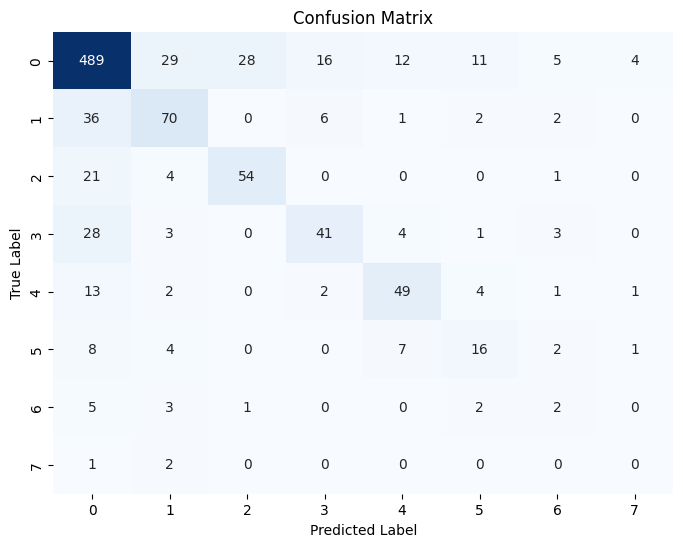

In [ ]:
conf_matrix = confusion_matrix(y_test, test_svm_class)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

GridSearch Linear SVC

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'loss': ['hinge', 'squared_hinge'],
    'max_iter': [1000, 2000, 3000],
    'penalty': ['l1', 'l2']
}

grid_search_SVC = GridSearchCV(svm.LinearSVC(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search_SVC.fit(train_tfidf, y_train)

print("Best parameters: ", grid_search_SVC.best_params_)
print("Best score: ", grid_search_SVC.best_score_)

Best parameters:  {'C': 0.1, 'loss': 'hinge', 'max_iter': 1000, 'penalty': 'l2'}
Best score:  0.6090136492402782


In [ ]:
grid_search_SVC = grid_search_SVC.best_estimator_

In [ ]:
test_svm_class_grid_search = grid_search_SVC.predict(test_tfidf)

print('\nClassification Report\n')
print(classification_report(y_test, test_svm_class_grid_search))


Classification Report

              precision    recall  f1-score   support

           0       0.89      0.59      0.71       594
           1       0.55      0.64      0.59       117
           2       0.51      0.78      0.62        80
           3       0.54      0.57      0.56        80
           4       0.47      0.79      0.59        72
           5       0.29      0.53      0.38        38
           6       0.10      0.31      0.15        13
           7       0.07      0.67      0.12         3

    accuracy                           0.62       997
   macro avg       0.43      0.61      0.46       997
weighted avg       0.73      0.62      0.65       997



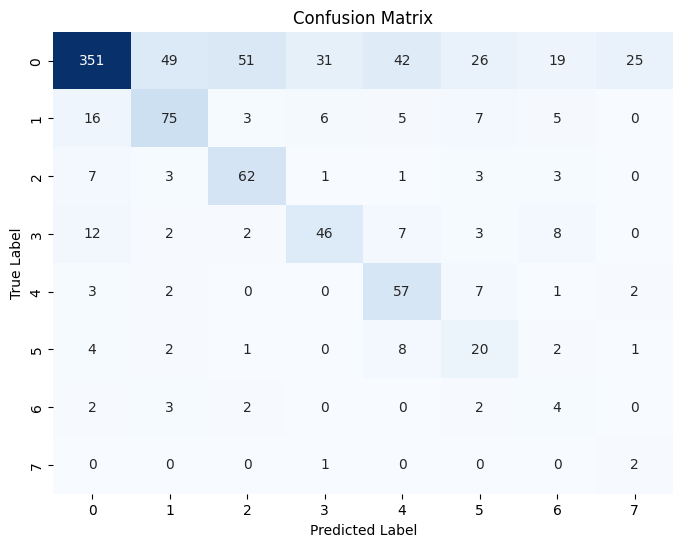

In [ ]:
conf_matrix = confusion_matrix(y_test, test_svm_class_grid_search)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### 2.1. Naive Bayes (MultinomialNB)

In [ ]:
multinomialnb_classifier = MultinomialNB()
multinomialnb_classifier.fit(train_tfidf, y_train)
test_nb_pred_multinomial = multinomialnb_classifier.predict(test_tfidf)

print('\nClassification Report\n')
print(classification_report(y_test, test_nb_pred_multinomial))


Classification Report

              precision    recall  f1-score   support

           0       0.85      0.61      0.71       594
           1       0.53      0.65      0.58       117
           2       0.55      0.69      0.61        80
           3       0.46      0.57      0.51        80
           4       0.46      0.76      0.57        72
           5       0.32      0.50      0.39        38
           6       0.10      0.23      0.14        13
           7       0.08      0.33      0.12         3

    accuracy                           0.62       997
   macro avg       0.42      0.54      0.46       997
weighted avg       0.69      0.62      0.64       997



### 2.2. Naive Bayes (ComplementNB)

In [ ]:
complementnb_classifier = ComplementNB()
complementnb_classifier.fit(train_tfidf, y_train)
test_nb_pred_complementnb = complementnb_classifier.predict(test_tfidf)

print('\nClassification Report\n')
print(classification_report(y_test, test_nb_pred_complementnb))


Classification Report

              precision    recall  f1-score   support

           0       0.86      0.46      0.60       594
           1       0.52      0.60      0.56       117
           2       0.45      0.78      0.57        80
           3       0.36      0.54      0.43        80
           4       0.41      0.74      0.52        72
           5       0.29      0.47      0.36        38
           6       0.05      0.15      0.07        13
           7       0.04      0.67      0.08         3

    accuracy                           0.53       997
   macro avg       0.37      0.55      0.40       997
weighted avg       0.68      0.53      0.56       997



### 2.3. Naive Bayes (BernoulliNB)

In [ ]:
bernoullinb_classifier = BernoulliNB()
bernoullinb_classifier.fit(train_tfidf, y_train)
test_nb_pred_bernoullinb = bernoullinb_classifier.predict(test_tfidf)

print('\nClassification Report\n')
print(classification_report(y_test, test_nb_pred_bernoullinb))


Classification Report

              precision    recall  f1-score   support

           0       0.80      0.74      0.77       594
           1       0.58      0.63      0.60       117
           2       0.64      0.61      0.62        80
           3       0.63      0.47      0.54        80
           4       0.43      0.71      0.54        72
           5       0.39      0.47      0.43        38
           6       0.08      0.08      0.08        13
           7       0.09      0.33      0.14         3

    accuracy                           0.67       997
   macro avg       0.46      0.51      0.47       997
weighted avg       0.70      0.67      0.68       997



### 3. Logistic Regression

In [ ]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(train_tfidf, y_train)
test_log_reg_pred = log_reg.predict(test_tfidf)

print('\nClassification Report\n')
print(classification_report(y_test, test_log_reg_pred))


Classification Report

              precision    recall  f1-score   support

           0       0.84      0.83      0.84       594
           1       0.61      0.69      0.65       117
           2       0.67      0.69      0.68        80
           3       0.68      0.54      0.60        80
           4       0.65      0.75      0.70        72
           5       0.53      0.47      0.50        38
           6       0.18      0.15      0.17        13
           7       0.00      0.00      0.00         3

    accuracy                           0.75       997
   macro avg       0.52      0.52      0.52       997
weighted avg       0.75      0.75      0.75       997



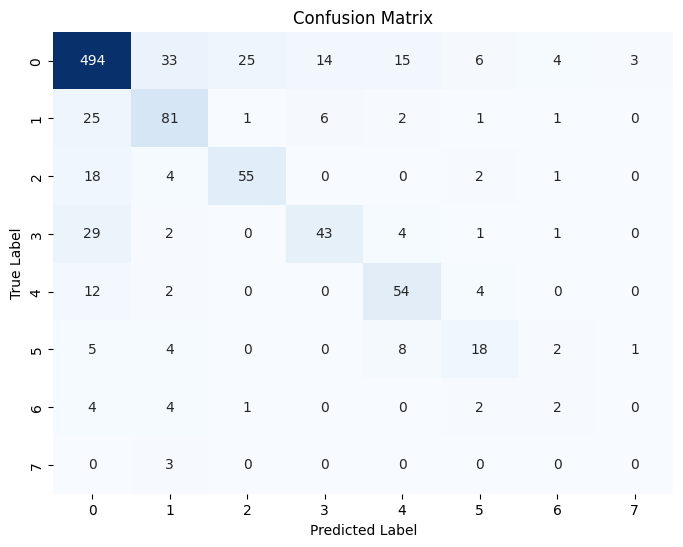

In [ ]:
conf_matrix = confusion_matrix(y_test, test_log_reg_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
file_path = '/content/drive/MyDrive/SATRIA DATA/PENYISIHAN/log_reg.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(log_reg, f)

GridSearch Logistic Regression

In [ ]:
param_grid = {
    'C': [0.1, 1, 5, 10],
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'solver': ['lbfgs', 'liblinear', 'saga']
}

grid_search_logreg = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search_logreg.fit(train_tfidf, y_train)

print("Best parameters: ", grid_search_logreg.best_params_)
print("Best score: ", grid_search_logreg.best_score_)

Best parameters:  {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best score:  0.588977594643317


In [ ]:
grid_search_logreg = grid_search_logreg.best_estimator_

In [ ]:
test_log_reg_pred_gridsearch = grid_search_logreg.predict(test_tfidf)

print('\nClassification Report\n')
print(classification_report(y_test, test_log_reg_pred_gridsearch))


Classification Report

              precision    recall  f1-score   support

           0       0.85      0.81      0.83       594
           1       0.57      0.68      0.62       117
           2       0.63      0.68      0.65        80
           3       0.68      0.54      0.60        80
           4       0.63      0.76      0.69        72
           5       0.49      0.47      0.48        38
           6       0.14      0.15      0.15        13
           7       0.00      0.00      0.00         3

    accuracy                           0.73       997
   macro avg       0.50      0.51      0.50       997
weighted avg       0.74      0.73      0.74       997



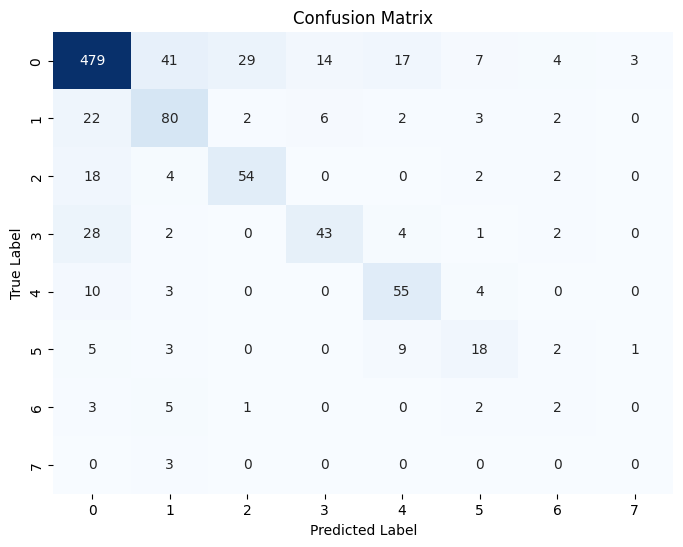

In [ ]:
conf_matrix = confusion_matrix(y_test, test_log_reg_pred_gridsearch)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### 4. Random Forest

In [ ]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(train_tfidf, y_train)
test_rf_pred = rf_classifier.predict(test_tfidf)

print('\nClassification Report\n')
print(classification_report(y_test, test_rf_pred))


Classification Report

              precision    recall  f1-score   support

           0       0.84      0.79      0.81       594
           1       0.48      0.69      0.57       117
           2       0.65      0.68      0.66        80
           3       0.68      0.51      0.59        80
           4       0.67      0.81      0.73        72
           5       0.71      0.45      0.55        38
           6       0.25      0.15      0.19        13
           7       0.00      0.00      0.00         3

    accuracy                           0.73       997
   macro avg       0.53      0.51      0.51       997
weighted avg       0.74      0.73      0.73       997



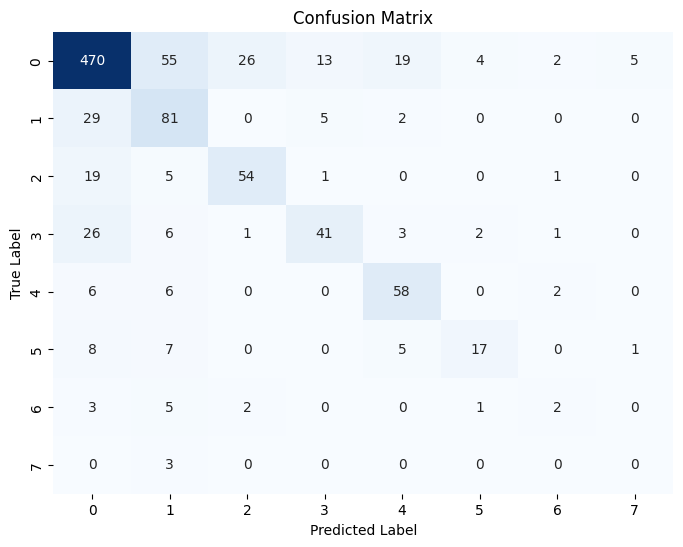

In [ ]:
conf_matrix = confusion_matrix(y_test, test_rf_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

GridSearch Random Forest

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 10, 20]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search_rf.fit(train_tfidf, y_train)

print("Best parameters: ", grid_search_rf.best_params_)
print("Best score: ", grid_search_rf.best_score_)

Best parameters:  {'criterion': 'gini', 'max_depth': None, 'n_estimators': 300}
Best score:  0.5758949266031419


In [ ]:
test_rf_pred_gridsearch = grid_search_rf.predict(test_tfidf)

print('\nClassification Report\n')
print(classification_report(y_test, test_rf_pred_gridsearch))


Classification Report

              precision    recall  f1-score   support

           0       0.83      0.80      0.82       594
           1       0.50      0.69      0.58       117
           2       0.66      0.66      0.66        80
           3       0.68      0.49      0.57        80
           4       0.64      0.81      0.72        72
           5       0.68      0.45      0.54        38
           6       0.22      0.15      0.18        13
           7       0.00      0.00      0.00         3

    accuracy                           0.73       997
   macro avg       0.53      0.51      0.51       997
weighted avg       0.74      0.73      0.73       997



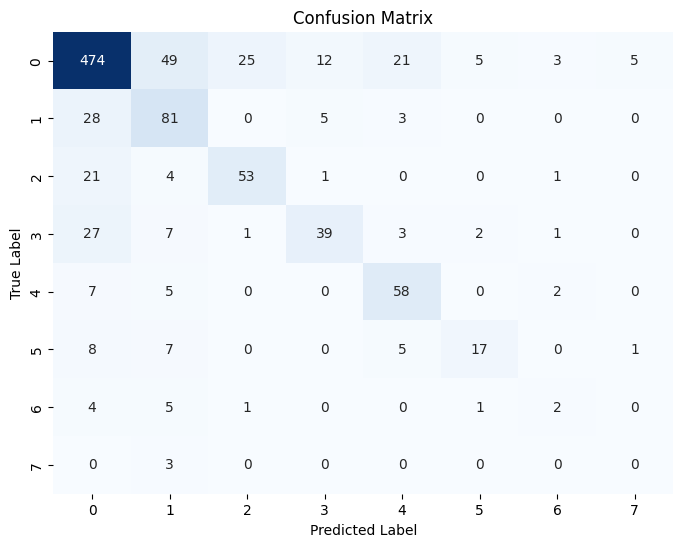

In [ ]:
conf_matrix = confusion_matrix(y_test, test_rf_pred_gridsearch)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### 5. Gradient Boosting

In [ ]:
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(train_tfidf, y_train)
test_gb_pred = gb_classifier.predict(test_tfidf)

print('\nClassification Report\n')
print(classification_report(y_test, test_gb_pred))


Classification Report

              precision    recall  f1-score   support

           0       0.85      0.69      0.76       594
           1       0.43      0.68      0.53       117
           2       0.62      0.69      0.65        80
           3       0.50      0.51      0.51        80
           4       0.62      0.75      0.68        72
           5       0.42      0.42      0.42        38
           6       0.13      0.23      0.17        13
           7       0.10      0.33      0.15         3

    accuracy                           0.66       997
   macro avg       0.46      0.54      0.48       997
weighted avg       0.71      0.66      0.68       997



### 6.1 Support Vector Machine (Poly)

In [ ]:
svm_poly_classifier = SVC(kernel='poly', random_state=42)
svm_poly_classifier.fit(train_tfidf, y_train)
test_svm_poly_pred = svm_poly_classifier.predict(test_tfidf)

print('\nClassification Report\n')
print(classification_report(y_test, test_svm_poly_pred))


Classification Report

              precision    recall  f1-score   support

           0       0.72      0.96      0.82       594
           1       0.80      0.37      0.50       117
           2       0.84      0.39      0.53        80
           3       0.85      0.44      0.58        80
           4       0.78      0.53      0.63        72
           5       0.71      0.32      0.44        38
           6       0.00      0.00      0.00        13
           7       0.00      0.00      0.00         3

    accuracy                           0.73       997
   macro avg       0.59      0.38      0.44       997
weighted avg       0.74      0.73      0.70       997



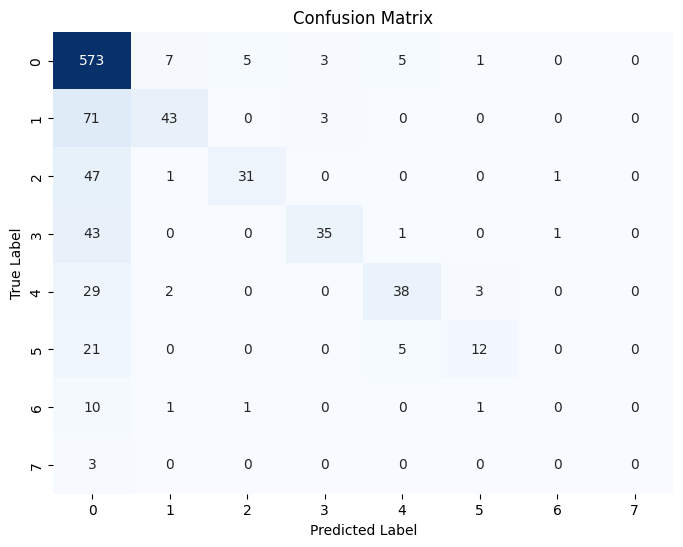

In [ ]:
conf_matrix = confusion_matrix(y_test, test_svm_poly_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### 6.2 Support Vector Machine (RBF)

In [ ]:
svm_rbf_classifier = SVC(kernel='rbf', random_state=42)
svm_rbf_classifier.fit(train_tfidf, y_train)
test_svm_rbf_pred = svm_rbf_classifier.predict(test_tfidf)

print('\nClassification Report\n')
print(classification_report(y_test, test_svm_rbf_pred))


Classification Report

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       594
           1       0.69      0.60      0.64       117
           2       0.72      0.62      0.67        80
           3       0.77      0.45      0.57        80
           4       0.75      0.69      0.72        72
           5       0.62      0.39      0.48        38
           6       0.00      0.00      0.00        13
           7       0.00      0.00      0.00         3

    accuracy                           0.76       997
   macro avg       0.54      0.46      0.49       997
weighted avg       0.75      0.76      0.75       997



### 6.3 Support Vector Machine (Sigmoid)

In [ ]:
svm_sigmoid_classifier = SVC(kernel='sigmoid', random_state=42)
svm_sigmoid_classifier.fit(train_tfidf, y_train)
test_svm_sigmoid_pred = svm_sigmoid_classifier.predict(test_tfidf)

print('\nClassification Report\n')
print(classification_report(y_test, test_svm_sigmoid_pred))


Classification Report

              precision    recall  f1-score   support

           0       0.82      0.81      0.82       594
           1       0.58      0.62      0.60       117
           2       0.68      0.68      0.68        80
           3       0.57      0.54      0.55        80
           4       0.64      0.71      0.67        72
           5       0.48      0.42      0.45        38
           6       0.10      0.08      0.09        13
           7       0.00      0.00      0.00         3

    accuracy                           0.72       997
   macro avg       0.48      0.48      0.48       997
weighted avg       0.72      0.72      0.72       997



### 7. K-Nearest Neighbors

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_tfidf, y_train)
test_knn_pred = knn_classifier.predict(test_tfidf)

print('\nClassification Report\n')
print(classification_report(y_test, test_knn_pred))


Classification Report

              precision    recall  f1-score   support

           0       0.83      0.60      0.70       594
           1       0.49      0.60      0.54       117
           2       0.47      0.66      0.55        80
           3       0.43      0.54      0.48        80
           4       0.44      0.67      0.53        72
           5       0.26      0.37      0.30        38
           6       0.04      0.08      0.05        13
           7       0.06      0.33      0.10         3

    accuracy                           0.59       997
   macro avg       0.38      0.48      0.41       997
weighted avg       0.67      0.59      0.61       997



# Inference

In [ ]:
path = "/content/drive/MyDrive/SATRIA DATA/PENYISIHAN/BDC-SatriaData-2024/dataset_unlabeled_penyisihan_bdc_2024.csv"

In [ ]:
df_testing = pd.read_csv(path, sep=None, engine='python')

### Preprocessing Text

In [ ]:
def remove_mentions(text):
    words = text.split()
    words = [word for word in words if not word.startswith('@')]
    return ' '.join(words)

def remove_re_pattern(text):
    pattern = r'\[RE [^\]]*\]'
    text = re.sub(pattern, '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def remove_re_pattern(text):
    pattern = r'\[RE [^\]]*\]'
    text = re.sub(pattern, '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def process_hashtags(text):
    def split_camel_case(s):
        return re.sub(r'([a-z])([A-Z])', r'\1 \2', s)
    words = text.split()
    processed_words = []
    for word in words:
        if word.startswith('#'):
            hashtag = word[1:]
            if hashtag.isupper():
                processed_words.append(hashtag)
            else:
                processed_words.extend(split_camel_case(hashtag).split())
        else:
            processed_words.append(word)
    return ' '.join(processed_words)

def cleansing(df):
    df_clean = df.str.lower()
    df_clean = [re.sub(r"http\S+|www\S+|https\S+", "", i, flags=re.MULTILINE) for i in df_clean]
    df_clean = [re.sub(r"\d+", "", i) for i in df_clean]
    df_clean = [re.sub(r'[^\x00-\x7F]+', '', i) for i in df_clean]
    df_clean = [re.sub(r'[^\w\s]', ' ', i) for i in df_clean]
    df_clean = [re.sub(r'\s+', ' ', i) for i in df_clean]
    df_clean = [re.sub(r'[^a-zA-Z0-9\s]', '', i) for i in df_clean]
    df_clean = [re.sub(r'_', ' ', i) for i in df_clean]
    return df_clean

def remove_trailing_spaces(text):
    text = text.strip()
    return text

In [ ]:
df_testing['Text'] = df_testing['Text'].apply(remove_mentions)
df_testing['Text'] = df_testing['Text'].apply(remove_re_pattern)
df_testing['Text'] = df_testing['Text'].apply(remove_re_pattern)
df_testing['Text'] = df_testing['Text'].str.replace(r'\brt\b', '', regex=True, case=False)
df_testing['Text'] = df_testing['Text'].apply(process_hashtags)

df_testing['Clean_Text'] = cleansing(df_testing['Text'])
df_testing['Clean_Text'] = df_testing['Clean_Text'].apply(remove_trailing_spaces)

In [ ]:
stopword = StopWord()
stopword_list = stopword.get_stopword()

def remove_stopwords(text):
    words = text.split()
    clean_words = [word for word in words if word not in stopword_list]
    return ' '.join(clean_words)

df_testing['Clean_Stopword'] = df_testing['Clean_Text'].apply(remove_stopwords)

### Text Representation: Advance BOW — TF-IDF

In [ ]:
vectorizer = TfidfVectorizer()
train_tfidf = vectorizer.fit_transform(x_train)
test_tfidf = vectorizer.transform(df_testing['Clean_Text'])

We chose Logistic Regression for inference because it is robust to class imbalance, offering a good balance between accuracy and interpretability. Its simpler structure makes it less prone to overfitting compared to more complex models, ensuring stable performance across all classes, even in an imbalanced dataset. Additionally, Logistic Regression is computationally efficient, making it a practical choice for quick and reliable predictions.

In [ ]:
file_path = '/content/drive/MyDrive/SATRIA DATA/PENYISIHAN/log_reg.pkl'
with open(file_path, 'rb') as f:
    log_reg_load = pickle.load(f)

In [ ]:
prediction = log_reg_load.predict(test_tfidf)

In [ ]:
df_testing['Predicted_Label'] = prediction

In [ ]:
df_inference = pd.DataFrame({
    'IDText': df_testing['IDText'],
    'Text': df_testing['Clean_Text'],
    'Predicted_Label': df_testing['Predicted_Label']
})

In [ ]:
label_to_class = {
    0: 'Politik',
    1: 'Sosial Budaya',
    2: 'Pertahanan dan Keamanan',
    3: 'Ideologi',
    4: 'Ekonomi',
    5: 'Sumber Daya Alam',
    6: 'Demografi',
    7: 'Geografi'
}

df_inference['Kelas'] = df_inference['Predicted_Label'].map(label_to_class)
df_inference = df_inference[['IDText', 'Text', 'Kelas']]

In [ ]:
df_final = df_inference[['IDText', 'Kelas']]

### Write to CSV

In [ ]:
file_path = '/content/drive/MyDrive/SATRIA DATA/PENYISIHAN/'
df_final.to_csv(file_path + 'jawaban_penyisihan_bdc_2024.csv', index=False)